In [35]:
%%time
%matplotlib inline
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import xgboost as xgb
from sklearn.metrics import matthews_corrcoef


from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import matthews_corrcoef, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV


from rgf.sklearn import RGFClassifier,RGFRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesClassifier,ExtraTreesRegressor
from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt
from scipy import stats
from scipy.stats import norm, skew 
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV,Ridge

Wall time: 3 ms


In [36]:
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import f1_score
from sklearn.metrics import fbeta_score

In [37]:
train =pd.read_csv('train_LZdllcl.csv')
test = pd.read_csv('test_2umaH9m.csv')
Ejm = pd.read_csv('sample_submission_M0L0uXE.csv')

In [38]:
train.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [39]:
test.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61


In [40]:
Ejm.head()

,employee_id,is_promoted
0,8724,0
1,74430,0
2,72255,0
3,38562,0
4,64486,0


In [41]:
train.info()
print('_ '*40)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54808 entries, 0 to 54807
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   employee_id           54808 non-null  int64  
 1   department            54808 non-null  object 
 2   region                54808 non-null  object 
 3   education             52399 non-null  object 
 4   gender                54808 non-null  object 
 5   recruitment_channel   54808 non-null  object 
 6   no_of_trainings       54808 non-null  int64  
 7   age                   54808 non-null  int64  
 8   previous_year_rating  50684 non-null  float64
 9   length_of_service     54808 non-null  int64  
 10  KPIs_met >80%         54808 non-null  int64  
 11  awards_won?           54808 non-null  int64  
 12  avg_training_score    54808 non-null  int64  
 13  is_promoted           54808 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.9+ MB
_ _ _ _ _ _ _

In [42]:
#Valores de cada columna 
for col in train.select_dtypes('O').columns:
    print(' {} valores unicos en {} : {}'.format(len(train[col].unique()),col,train[col].unique()))
    print('__'*30)

 9 valores unicos en department : ['Sales & Marketing' 'Operations' 'Technology' 'Analytics' 'R&D'
 'Procurement' 'Finance' 'HR' 'Legal']
____________________________________________________________
 34 valores unicos en region : ['region_7' 'region_22' 'region_19' 'region_23' 'region_26' 'region_2'
 'region_20' 'region_34' 'region_1' 'region_4' 'region_29' 'region_31'
 'region_15' 'region_14' 'region_11' 'region_5' 'region_28' 'region_17'
 'region_13' 'region_16' 'region_25' 'region_10' 'region_27' 'region_30'
 'region_12' 'region_21' 'region_8' 'region_32' 'region_6' 'region_33'
 'region_24' 'region_3' 'region_9' 'region_18']
____________________________________________________________
 4 valores unicos en education : ["Master's & above" "Bachelor's" nan 'Below Secondary']
____________________________________________________________
 2 valores unicos en gender : ['f' 'm']
____________________________________________________________
 3 valores unicos en recruitment_channel : ['sourcin

In [43]:
# correlaciones
corr = train.corr()
corr['is_promoted'].sort_values(ascending=False)[1:15].to_frame()\
.style.background_gradient(axis=1,cmap=sns.light_palette('green', as_cmap=True))

,is_promoted
KPIs_met >80%,0.221582
awards_won?,0.195871
avg_training_score,0.181147
previous_year_rating,0.159320
employee_id,0.001206
length_of_service,-0.010670
age,-0.017166
no_of_trainings,-0.024896


In [44]:
train.isna().sum()
test.isna().sum()

employee_id                0
department                 0
region                     0
education               1034
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    1812
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
dtype: int64

In [45]:
train['previous_year_rating'].replace(np.nan,3.,inplace=True)
test['previous_year_rating'].replace(np.nan,3.,inplace=True)

In [46]:
train.isna().sum()
test.isna().sum()

employee_id                0
department                 0
region                     0
education               1034
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating       0
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
dtype: int64

# Analisis visual

<AxesSubplot:>

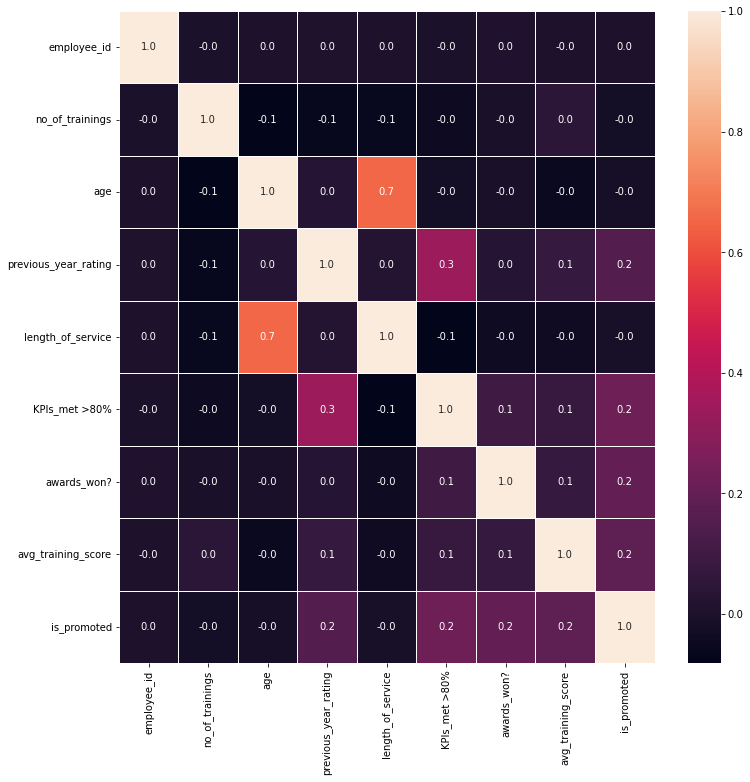

In [47]:
f,ax=plt.subplots(figsize=(12,12))
sns.heatmap(train.corr(),annot=True,linewidths=.5,fmt='.1f',ax=ax)

In [ ]:
# Eliminando la columna employee_id ya que no proporciona ninguna información
train.drop('employee_id',axis=1,inplace=True)

Numero de promovidos: 
0    50140
1     4668
Name: is_promoted, dtype: int64



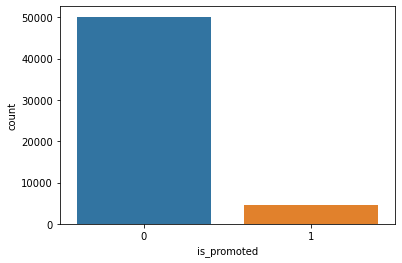

In [48]:
### análisis para los  promovidos 
print('Numero de promovidos: ')
print(train['is_promoted'].value_counts())
print()
sns.countplot(x='is_promoted', data=train)
plt.show()

In [53]:
#Porcentaje de personas promovidas 

prom = (4668/54808)*100
print("El porcentaje de personas promovidas es  {:.2f}%".format(prom))

El porcentaje de personas promovidas es  8.52%


Observaciones::
1. hay un desequilibrio de datos 
2. solo el 8,52% de los empleados son recomendados para promoción

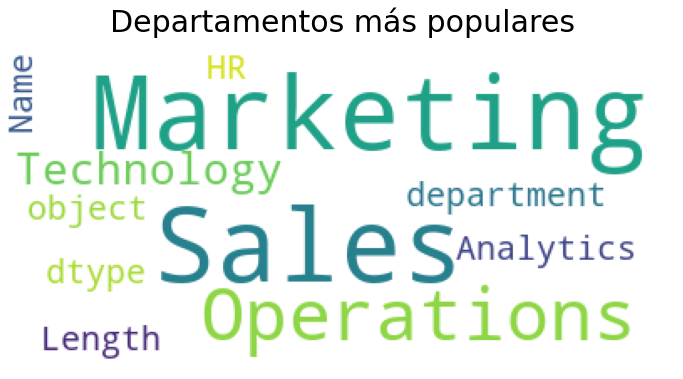

In [55]:
# mirando los departamentos más populares

from wordcloud import WordCloud
from wordcloud import STOPWORDS

stopword = set(STOPWORDS)

wordcloud = WordCloud(background_color = 'white', stopwords = stopword).generate(str(train['department']))

plt.rcParams['figure.figsize'] = (12, 8)
print(wordcloud)
plt.imshow(wordcloud)
plt.title('Departamentos más populares', fontsize = 30)
plt.axis('off')
plt.show()

Observaciones:
1. Los departamentos mas grandes son el de marketin y ventas. 

Percentage of Department: 


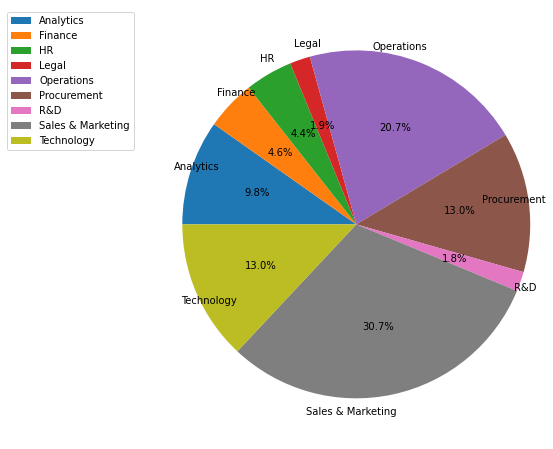

In [58]:
# Análisis de la variable Departament
plt.figure(figsize=(12,8))
print("Percentage of Department: ")
labels = train.groupby(['department'])['department'].count().index
plt.pie(train.groupby(['department'])['department'].count()/train.shape[0] * 100, autopct='%1.1f%%',  labels= labels)
plt.legend()
plt.xlim(1.5)
plt.show()

Observaciones:
1. El 51% de los empleados pertenecen a Marketing de Ventas (30,9%) y Operaciones (20,6%)
2. La menor cantidad de empleados pertenece al departamento legal (1,8%) y de I + D (1,8%)

# Variables independientes Análisis explicativo de datos

<AxesSubplot:xlabel='department', ylabel='avg_training_score'>

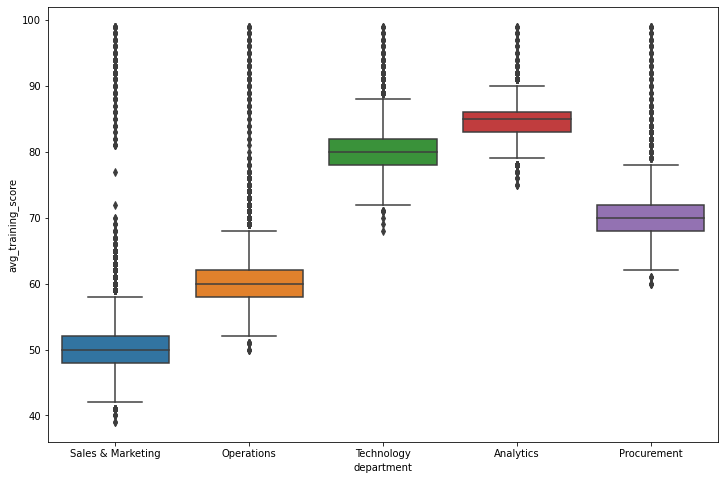

In [16]:
# Puntaje promedio avg_training_score
df= train[train.department.isin(train.department.value_counts().head().index)]
sns.boxplot(x='department',y='avg_training_score',data=df)

In [17]:
# descripción de las variables numéricas
train['avg_training_score'].describe()

count    54808.000000
mean        63.386750
std         13.371559
min         39.000000
25%         51.000000
50%         60.000000
75%         76.000000
max         99.000000
Name: avg_training_score, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


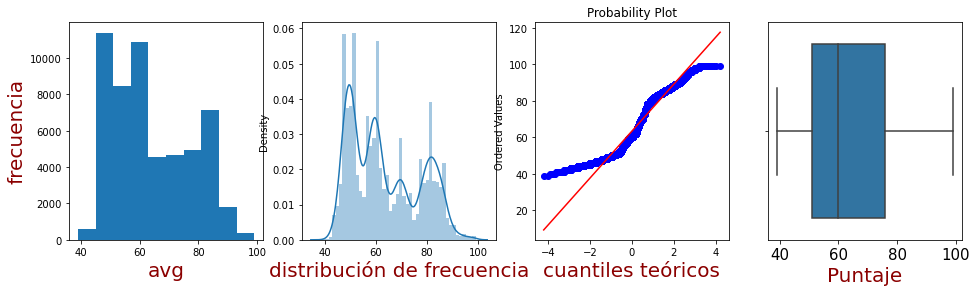

In [57]:
# gráficas para avg 
plt.figure(figsize=(16,4))

plt.subplot(1,4,1)
plt.hist(train['avg_training_score'])
plt.xlabel("avg", fontsize = 20,  color = 'darkred')
plt.ylabel("frecuencia", fontsize = 20, color = 'darkred')

plt.subplot(1,4,2)
sns.distplot(train['avg_training_score'] )
plt.xlabel("distribución de frecuencia", fontsize = 20, color = 'darkred')

plt.subplot(1,4,3)
stats.probplot(train['avg_training_score'], dist= 'norm', plot= plt)
plt.xlabel("cuantiles teóricos", fontsize = 20, color = 'darkred')

plt.subplot(1,4,4)
sns.boxplot(train['avg_training_score'])
plt.xlabel("Puntaje", fontsize = 20,  color = 'darkred')
plt.xticks(fontsize = 15)

plt.show()

In [19]:
#### Comprobar la asimetría de la puntuación media de entrenamiento ####
train['avg_training_score'].skew()

0.45190808551707995

Observaciones :
1. datos se encuentran moderadamente sesgados a la derecha por lo tanto la media es mayor que la mediana
2. El 50% de la calificación promedio de capacitación de los empleados se encuentra en el rango de 51 a 76

In [20]:
##descripción de previous_year_rating
train['previous_year_rating'].describe()

count    54808.000000
mean         3.304481
std          1.214770
min          1.000000
25%          3.000000
50%          3.000000
75%          4.000000
max          5.000000
Name: previous_year_rating, dtype: float64

Observaciones:
1. El 50% de los años de servicio de los empleados se encuentra entre 3 y 7 años.
2. los años mínimos de servicio de experiencia de cualquier empleado son 1 año y el máximo es 37 años
3. El 75% de la experiencia de servicio de los empleados es menor o igual a 7 años.
4. Por lo tanto, en función de la distribución de datos, cree contenedores basados ​​en cuantiles de años de servicio

In [21]:
#### descripción de la variable de edad 
train['age'].describe()

count    54808.000000
mean        34.803915
std          7.660169
min         20.000000
25%         29.000000
50%         33.000000
75%         39.000000
max         60.000000
Name: age, dtype: float64

Observaciones:
1. la edad mínima del empleado es de 20 años y la edad máxima del empleado es de 60 años
2. 50% de los empleados tienen entre 29 y 39 años de edad
3. 75% de los empleados tienen menos de 40 años
4. Por lo tanto, en función de la distribución de datos, cree contenedores basados en cuantiles de edades. 

In [24]:
col_name = train.columns.to_list()
col_name

['department',
 'region',
 'education',
 'gender',
 'recruitment_channel',
 'no_of_trainings',
 'age',
 'previous_year_rating',
 'length_of_service',
 'KPIs_met >80%',
 'awards_won?',
 'avg_training_score',
 'is_promoted']

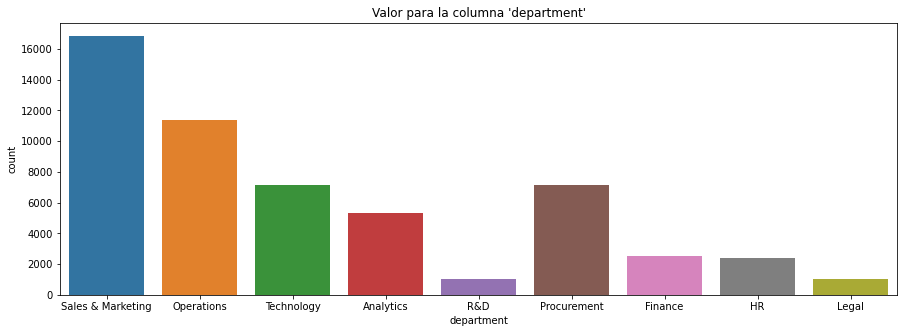

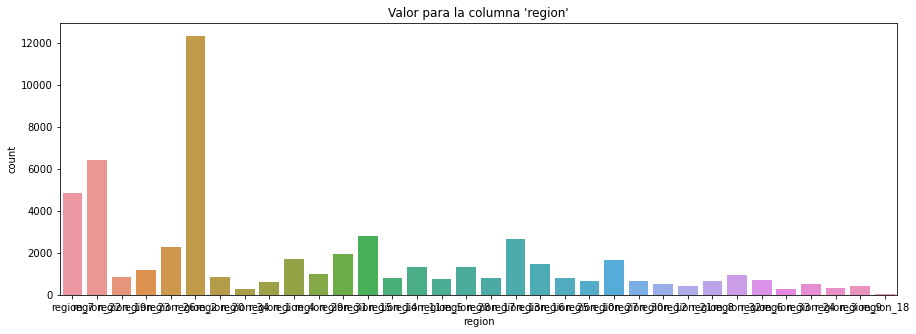

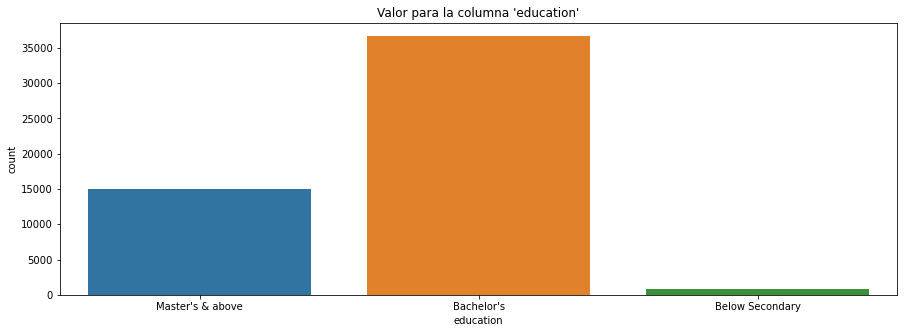

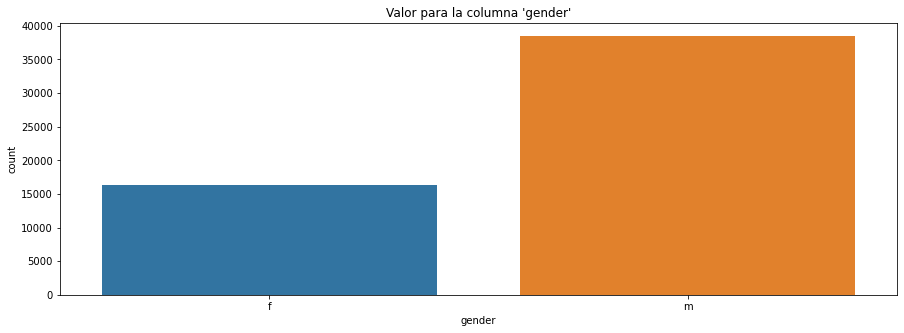

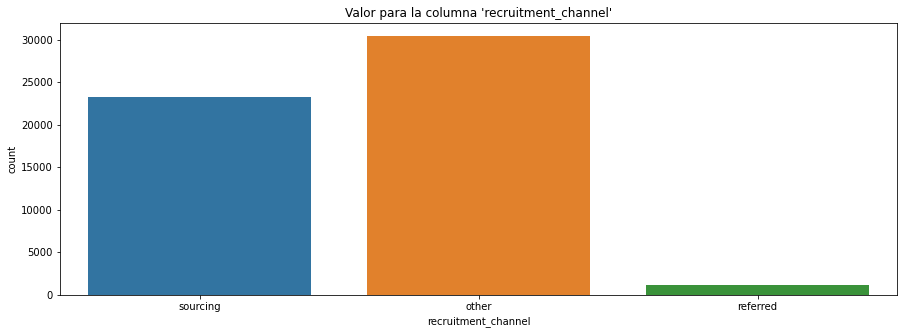

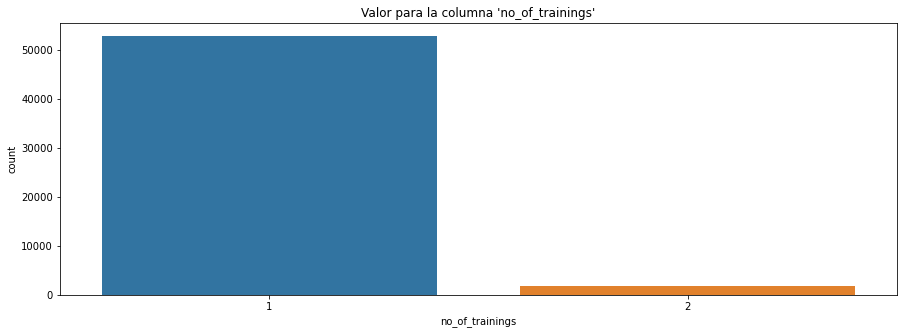

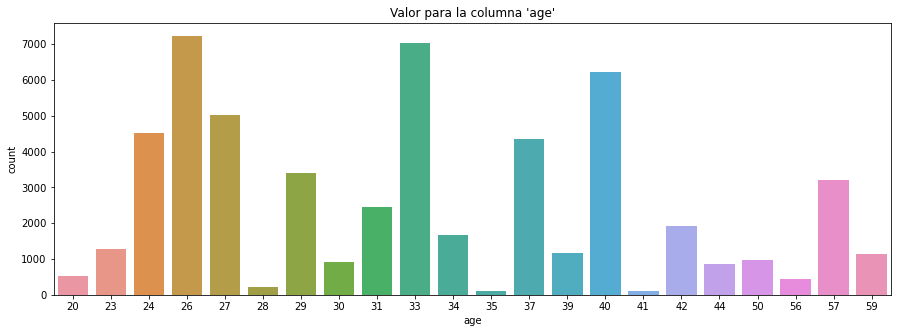

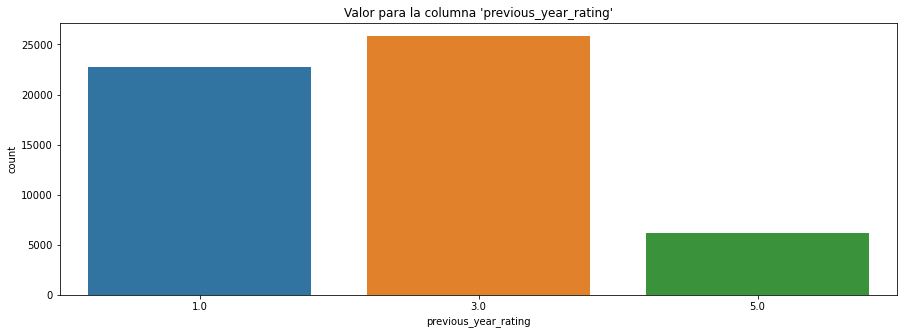

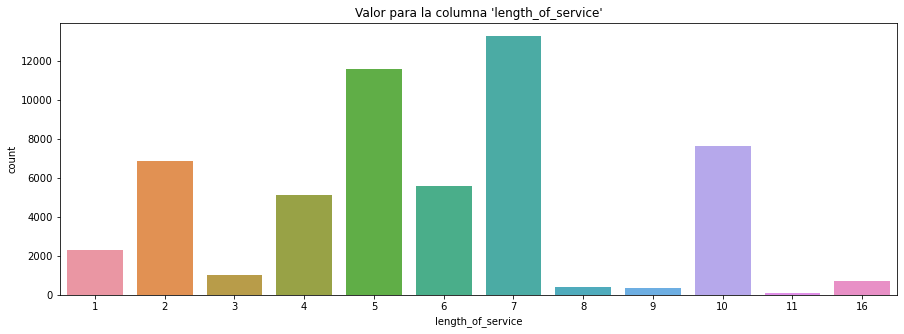

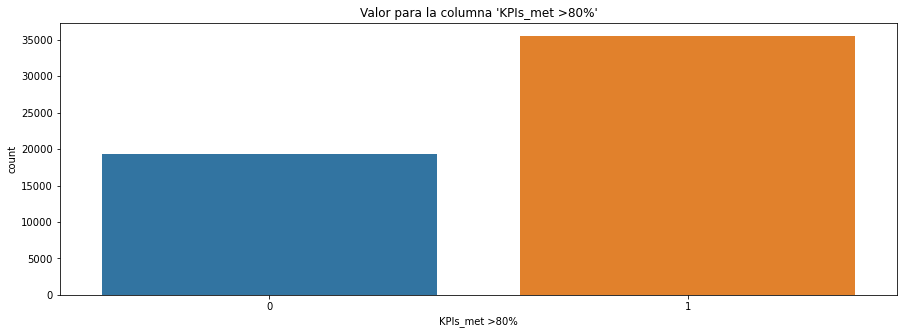

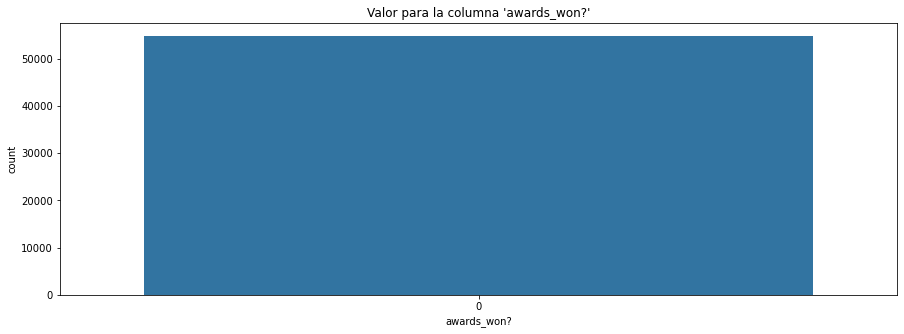

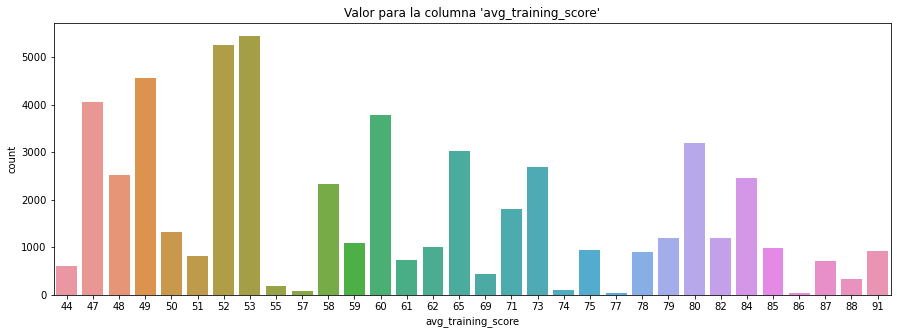

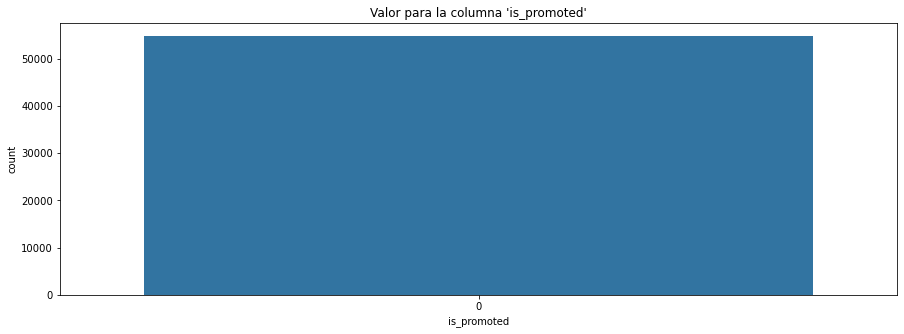

In [59]:
# para calcular el valor de cada columna 
for i in col_name:
    plt.figure(figsize=(15,5))
    plt.title("Valor para la columna '{}'".format(i))
    sns.countplot(x=train[i], data=train[i])
    plt.show()

<AxesSubplot:xlabel='department', ylabel='avg_training_score'>

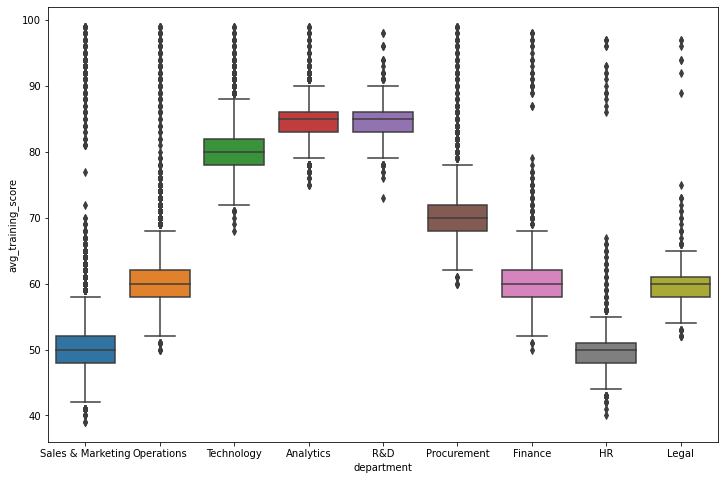

In [26]:
df= train[train.department.isin(train.department.value_counts().head(10).index)]
sns.boxplot(x='department',y='avg_training_score',data=train)



<AxesSubplot:xlabel='KPIs_met >80%', ylabel='count'>

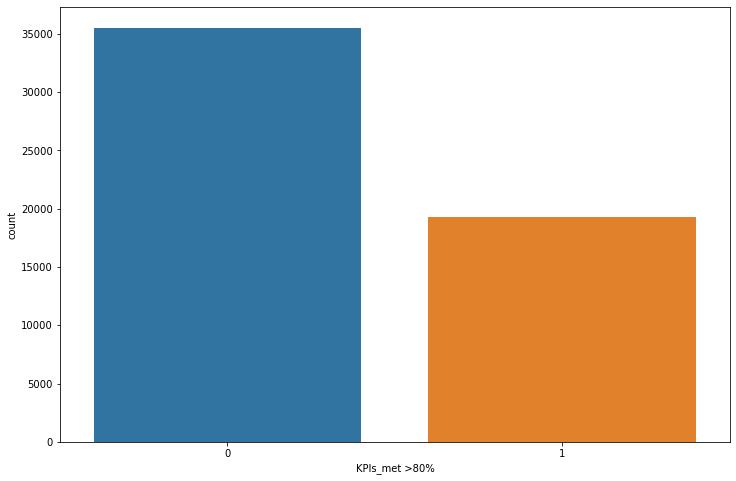

In [27]:
sns.countplot(x=train['KPIs_met >80%'],data=train)


In [60]:
train['KPIs_met >80%'].value_counts()

0    35517
1    19291
Name: KPIs_met >80%, dtype: int64

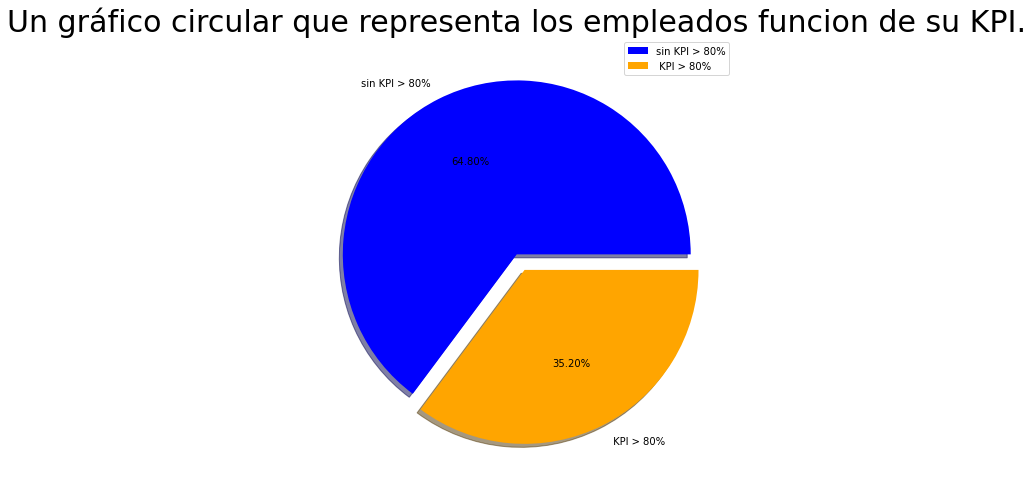

In [62]:
size = [35517, 19291]
labels = "sin KPI > 80%", " KPI > 80%"
colors = ['Blue', 'orange']
explode = [0, 0.1]

plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, labels = labels, colors = colors, explode = explode, shadow = True, autopct = "%.2f%%")
plt.title('Un gráfico circular que representa los empleados funcion de su KPI.', fontsize = 30)
plt.axis('off')
plt.legend()
plt.show()

Observaciones:

<AxesSubplot:xlabel='is_promoted', ylabel='avg_training_score'>

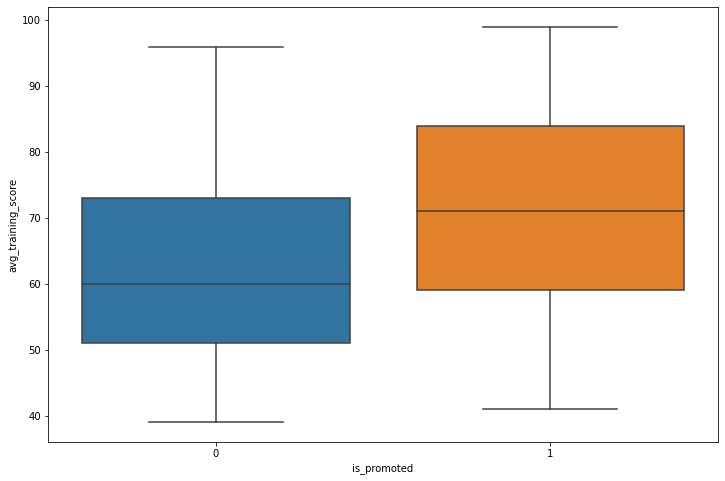

In [28]:
sns.boxplot(x='is_promoted',y='avg_training_score',data=train)

ovservaciones 


# Procesamiento de los datos 

In [29]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

train['department'] = le.fit_transform(train['department'])
test['department'] = le.transform(test['department'])

In [30]:
train['region'] = le.fit_transform(train['region'])
test['region'] = le.transform(test['region'])
train['education'] = le.fit_transform(train['education'])
test['education'] = le.transform(test['education'])
train['gender'] = le.fit_transform(train['gender'])
test['gender'] = le.transform(test['gender'])

train['recruitment_channel'] = le.fit_transform(train['recruitment_channel'])
test['recruitment_channel'] = le.transform(test['recruitment_channel'])

In [31]:
train.head()

,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,7,31,2,0,2,1,35,5.0,8,1,0,49,0
1,4,14,0,1,0,1,30,5.0,4,0,0,60,0
2,7,10,0,1,2,1,34,3.0,7,0,0,50,0
3,7,15,0,1,0,2,39,1.0,10,0,0,50,0
4,8,18,0,1,0,1,45,3.0,2,0,0,73,0


# Modelos 

In [32]:
Y1=train['is_promoted']

train1=train.drop(['is_promoted','recruitment_channel'],axis=1)
train1=train1.values
Y=Y1.values


test1 = test.drop(['recruitment_channel'],axis=1)
test1=test1.values

In [ ]:
# modelos a realizar

base_models = {"Elastic Net":make_pipeline(RobustScaler(),                    #modelo 1 
                                            ElasticNet(alpha=0.0005,
                                                       l1_ratio=0.9)),
               "Kernel Ridge" :KernelRidge(),                                 #modelo 2
               "Lasso" : make_pipeline(RobustScaler(), Lasso(alpha =0.0005,   #modelo 3
                                                             random_state=1)),
               "Random Forest": RandomForestRegressor(n_estimators=300),      #modelo 4
               "SVM": SVR(),                                                  #modelo 5
               "XGBoost": XGBRegressor(),                                     #modelo 6
               "LGBM" : LGBMRegressor(objective='regression',num_leaves=5,
                                      learning_rate=0.05, n_estimators=720,
                                      max_bin = 55, bagging_fraction = 0.8,
                                      bagging_freq = 5, feature_fraction = 0.2319,
                                      feature_fraction_seed=9, bagging_seed=9,
                                      min_data_in_leaf =6, min_sum_hessian_in_leaf = 11),                                              
               "Gradient Boosting":make_pipeline(StandardScaler(),
                                                 GradientBoostingRegressor(n_estimators=3000, #modelo 7
                                                                           learning_rate=0.005,     
                                                                           max_depth=4, max_features='sqrt',
                                                                           min_samples_leaf=15, min_samples_split=10, 
                                                                           loss='huber', random_state =5))}